# Dimensionality reduction via PCA, t-SNE and deep Boltzmann machines

We investigate the potential of DBMs for dimensionality reduction based on single-cell gene expression data. For this purpose, we compare the two-dimensional representations that we get from applying PCA, t-SNE and a combined approach of DBMs and PCA to a single-cell RNA-seq data set.

We employ data from Tasic et al. (2016) who investigated gene expression in 1525 single neurons, extracted from the cortices of mice. They reported a set of 104 genes (Figure 3 of Tasic et al.), based on which different subtypes of neurons can be discriminated and a set of 80 neurotransmitter receptor genes (Figure S15 of Tasic et al.), totalling to 184 genes. 

We here model the expression of these 184 genes using a DBM and use the non-linear transformation, learned by the DBM to retrieve a compact representation of the expression data, which allows for a good separation of the different cell types in two dimensions. 


## Loading the data
Prior to modeling, we normalize the single-cell RNA-Seq data of Tasic et al. for sequencing depth using DESeq (Anders and Huber, 2010) and then log transformed the expression data of the above defined marker and neurotransmitter receptor genes. Afterwards the data is standardized.

We attached the preprocessed data as a ".jld" file and can simply load it here. The gene expression data matrix `mat` contains the samples in the rows. The `subtype` vector contains the corresponding cell subtypes.

In [5]:
using JLD
data = JLD.load("scrnaseq_neurons.jld")
mat = data["mat"];
subtype = data["subtype"];

## PCA
For performing PCA, we simply need to compute the first two principal components from the data.

In [6]:
using Statistics
function standardize(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

using LinearAlgebra
function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end

pcaout = prcomps(mat);

## t-SNE

The t-SNE hyperparameters we used are:
* 2 as number of dimensions
* 50 dimensions as initial dimension reduction via PCA
* 1000 iterations
* perplexity 20.0.


In [22]:
using TSne
tsneout = tsne(mat, 2, 50, 1000, 20.0; progress = false);

To evaluate the hyperparameters of t-SNE, we can take a range of possible hyperparameters and visualize the dimensionality reduction:

In [8]:
using Distributed
addprocs(Sys.CPU_THREADS - nprocs() + 1)
@everywhere using TSne
@everywhere using DataFrames
@eval @everywhere mat = $mat
@eval @everywhere subtype = $subtype
@everywhere function tsne_mat(pcadim_perplexity)
   tsneout = tsne(mat, 2, 50, 1000, 20.0; progress = false)
   DataFrame(tSNE1 = tsneout[:, 1], tSNE2 = tsneout[:, 2],
         pcadim = pcadim_perplexity[1], perplexity = pcadim_perplexity[2],
         Celltype = subtype)
end
@time tsnedf = vcat(map(tsne_mat, Iterators.product(50:50:200, float.(20:10:50)))...);

211.862943 seconds (21.13 M allocations: 2.556 GiB, 0.54% gc time)


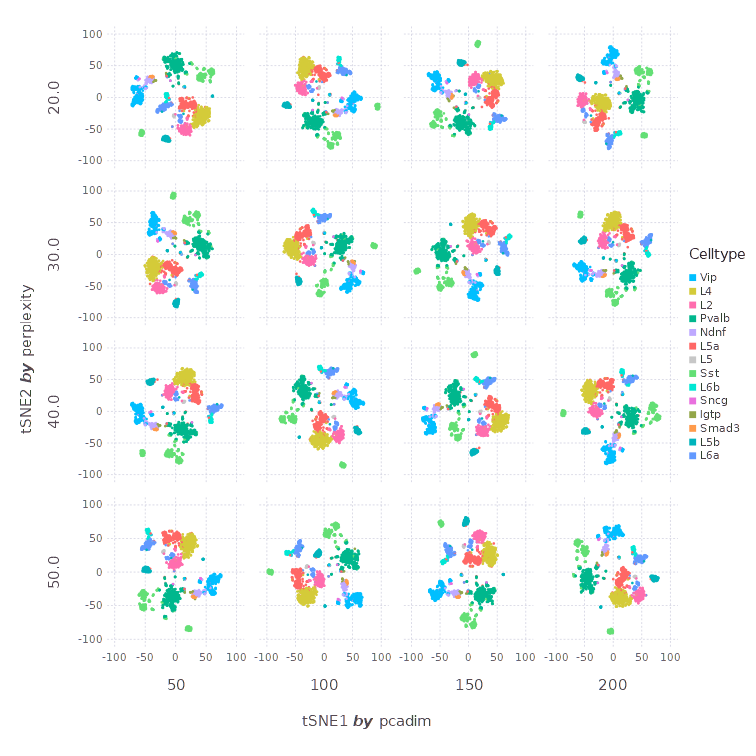

false

In [21]:
using Gadfly
using Cairo
draw(PNG(20cm, 20cm), plot(tsnedf,
      xgroup = "pcadim", ygroup = "perplexity", x = "tSNE1", y = "tSNE2", color = "Celltype",
      Geom.subplot_grid(Geom.point), Theme(highlight_width = 0pt, point_size = 1pt)))

# DBM

Prior to modeling with the DBM, we transform the values of each gene into the interval \[0,1\].

In [10]:
using BoltzmannMachines
intensitydata = intensities(mat);

The following function returns a random permutation of the rows of an expression matrix, which we can then use to split the original data into a training and a test data set.


In [11]:
using Random

function randomsplit(n, prop = 0.5)
   breakpoint = round(Int, prop*n)
   shuffled = randperm(n)
   return shuffled[1:breakpoint], shuffled[(breakpoint + 1):n]
end

Random.seed!(1)
trainidxs, testidxs = randomsplit(size(mat, 1), 0.632)
trainingdata = intensitydata[trainidxs,:]
testdata = intensitydata[testidxs,:];

For training the DBM, we use three hidden layers:
100 nodes in first hidden layer, 20 in second and 10 in third. 

We will visualize the activations of the 10 nodes in the last layer with PCA.

We evaluated several models and training epochs in a grid search and use the model with the best lower bound of the likelihood on the test data. 

In [12]:
bestresult = (31, 5, 3000)
gridsearch = false;

In case you want to reproduce the hyperparameter selection, i.e. the content of `bestresult`, you have to set `gridsearch = true`. 
(If set, the search might run for multiple hours in case you donˋt have a computer with multiple cores or a computer cluster.)

In [13]:
do_grid_search = false
using Distributed
if gridsearch
    addprocs(Sys.CPU_THREADS - nprocs() + 1)

    @everywhere using BoltzmannMachines
    @everywhere using Random
    
    # Transfer the data to all processes
    @eval @everywhere trainingdata = $trainingdata
    @eval @everywhere testdata = $testdata

    @everywhere function trainandeval(randomseed, epochspre, epochsdbm)
        Random.seed!(randomseed) # set a seed in the current process for reproducibility

        dbm = BoltzmannMachines.fitdbm(trainingdata, nhiddens = [100, 20, 10],
             epochs = epochsdbm,
             learningrate = 0.001, learningratepretraining = 0.001,
             epochspretraining = epochspre, batchsizepretraining = 10)

        lplb = BoltzmannMachines.logproblowerbound(dbm, testdata)

        randomseed, epochspre, epochsdbm, dbm, lplb
    end

    epochsprelist = [100, 1000, 2000, 3000, 4000]
    epochsdbmlist = [5, 10, 20]
    randomseeds = collect(1:10:100)

    @time trainingresult = vcat(pmap(params -> trainandeval(params[1], params[2], params[3]),
          Iterators.product(randomseeds, epochsprelist, epochsdbmlist))...);

    bestresult = trainingresult[findmin(map(r -> r[5], trainingresult))[2]]
end

Train the DBM with the best parameters:

In [14]:
Random.seed!(bestresult[1])
@time dbm = BoltzmannMachines.fitdbm(trainingdata,
      nhiddens = [100, 20, 10], epochs = bestresult[2],
      learningrate = 0.001, learningratepretraining = 0.001,
      epochspretraining = bestresult[3], batchsizepretraining = 10);

155.951009 seconds (45.42 M allocations: 7.232 GiB, 2.54% gc time)


Get the linearized activations of the last layer's hidden nodes for each sample.

In [15]:
dbmout = logit.(BoltzmannMachines.meanfield(dbm, intensitydata)[end]);
pcadbmout = prcomps(dbmout, true);

## Comparison

In [16]:
using Gadfly
using DataFrames

plotdata = DataFrame(
    DBM_PC1 = pcadbmout[:,1], DBM_PC2 = pcadbmout[:,2],
    tSNE1 = tsneout[:,1], tSNE2 = tsneout[:,2],
    PC1 = pcaout[:,1], PC2 = pcaout[:,2],
    Celltype = subtype);

We evaluate the three approaches on the test data:

In [17]:
plotdata = plotdata[testidxs,:];

If you would like to examine the plots more closely, you can switch cell types on and off by clicking at the plots' legend.

### PCA plot

We visualize the first two principal components of the log transformed and standardized data:

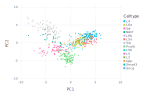

In [18]:
plot(plotdata, x=:PC1, y=:PC2, color=:Celltype, 
    Theme(highlight_width = 0pt, point_size = 1.5pt))

### t-SNE plot

The t-SNE prepresentation of the log transformed and standardized data:

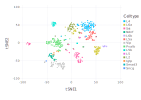

In [19]:
plot(plotdata, x = :tSNE1, y = :tSNE2, color=:Celltype, 
    Theme(highlight_width = 0pt, point_size = 1.5pt))

### DBM/PCA plot

We visualize the first two principal components, computed from the activations in the 10 hidden nodes in the terminal hidden layer of the trained DBM:

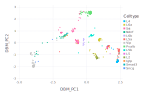

In [20]:
plot(plotdata, x=:DBM_PC1, y=:DBM_PC2, color=:Celltype, 
    Theme(highlight_width = 0pt, point_size = 1.5pt))

### Conclusion

As one can observe from the three visualizations, the transformations learned by the DBM allow for a discrimination of different cell types. The separation of different cell types is much better as compared with the results from the PCA and the distinct subgroups in the DBM/PCA approach are also clearer than that of the t-SNE.

Please note that representations derived from t-SNE and PCA were computed based on all training examples while the representations derived from the DBM were computed from only 63.2% of the data, which further indicates the potential of the DBM for retrieving good representations from genomics data.

## Literature

Tasic, B., V. Menon, T. N. Nguyen, T. K. Kim, T. Jarsky, Z. Yao, B. Levi, L. T. Gray, S. A. Sorensen, T. Dolbeare, et al. (2016). *Adult mouse cortical cell taxonomy revealed by single cell transcriptomics*. Nature neuroscience 19(2), 335.

Anders, S., & Huber, W. (2010). *Differential expression analysis for sequence count data*. Genome biology, 11(10), R106.

L.J.P. van der Maaten and G.E. Hinton. *Visualizing High-Dimensional Data Using t-SNE*. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.